In [2]:
import mne, mne_bids
mne.set_config('MNE_BROWSER_BACKEND', 'matplotlib') # To plot in the notebook using matplotlib
import sys
sys.path.insert(0, '.')
import ccs_eeg_utils

%matplotlib inline

Attempting to create new mne-python configuration file:
/Users/edward/.mne/mne-python.json
Using matplotlib as 2D backend.


In [8]:
from mne_bids import BIDSPath, read_raw_bids

# path where to save the datasets.
bids_root = "../../../../Datasets/project-dataset//"
subject_id = '01' #


bids_path = BIDSPath(subject=subject_id,task="run5",
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

In [ ]:
# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)
raw.load_data()
raw.set_eeg_reference("average")
raw.set_montage('standard_1020',match_case=False)


In [5]:
# Let's downsample to 200Hz to speed up calculations
raw_downsampled = raw_f.resample(200)

In [6]:
# Break raw data into 1 s epochs
tstep = 1
events_ica = mne.make_fixed_length_events(raw_downsampled, duration=tstep)
epochs_ica = mne.Epochs(raw_downsampled, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Not setting metadata
539 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 539 events and 201 original time points ...
1 bad epochs dropped


In [7]:
# Finding bad epochs using autoreject

from autoreject import AutoReject

ar = AutoReject(n_interpolate=[1, 2, 4],
                random_state=42,
                picks=mne.pick_types(epochs_ica.info, 
                                     eeg=True,
                                     eog=False
                                    ),
                n_jobs=-1, 
                verbose=False
                )

ar.fit(epochs_ica)
reject_log = ar.get_reject_log(epochs_ica)


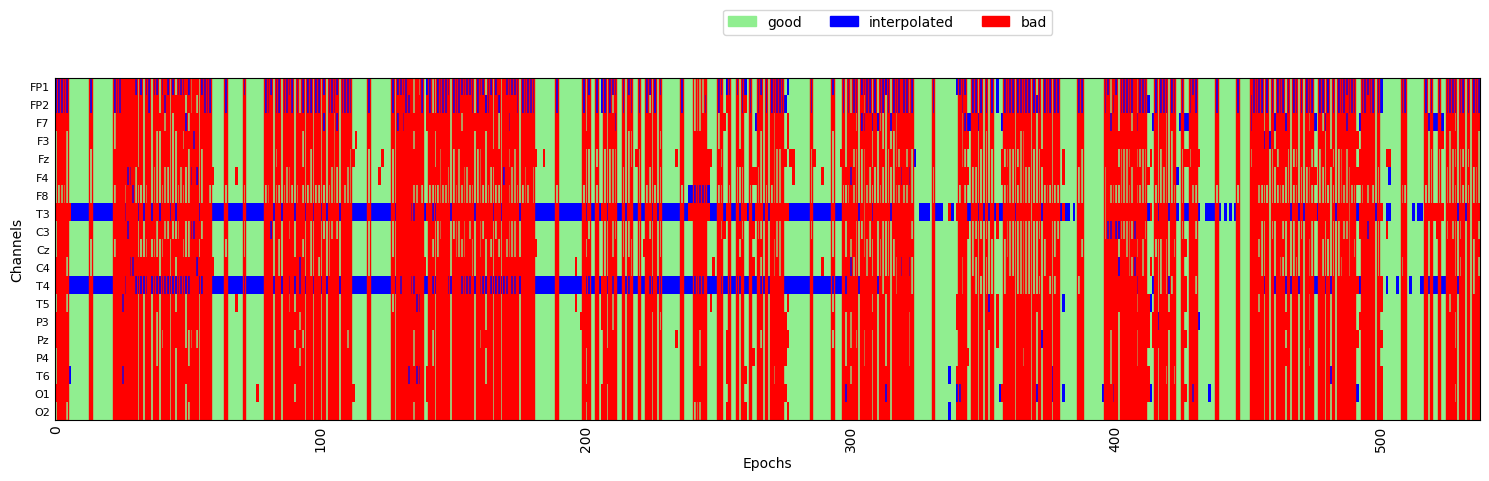

In [8]:
# Plotting rejected epochs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[15, 5])
reject_log.plot('horizontal', ax=ax, aspect='auto')
plt.show()

In [ ]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            # method='picard',
                            method = 'infomax',
                            fit_params=dict(extended=True)
                            )
ica.fit(epochs_ica[~reject_log.bad_epochs], decim=3)

ica.plot_components();
# plot the ica sources
ica.plot_sources(raw_f, show_scrollbars=False, start = 30, stop = 40)
# Auto generate labels from the ICA sources 
from mne_icalabel import label_components

ic_labels = label_components(raw_downsampled, ica, method="iclabel")

# Plot the ICA removed data on the raw data
ica.plot_overlay(raw_downsampled,exclude=exclude_idx)

In [ ]:
def run_corrca(X, n_components=3):
    # CorrCA is like CCA with same input twice
    cca = CCA(n_components=n_components)
    cca.fit(X, X)
    X_c, _ = cca.transform(X, X)
    return X_c

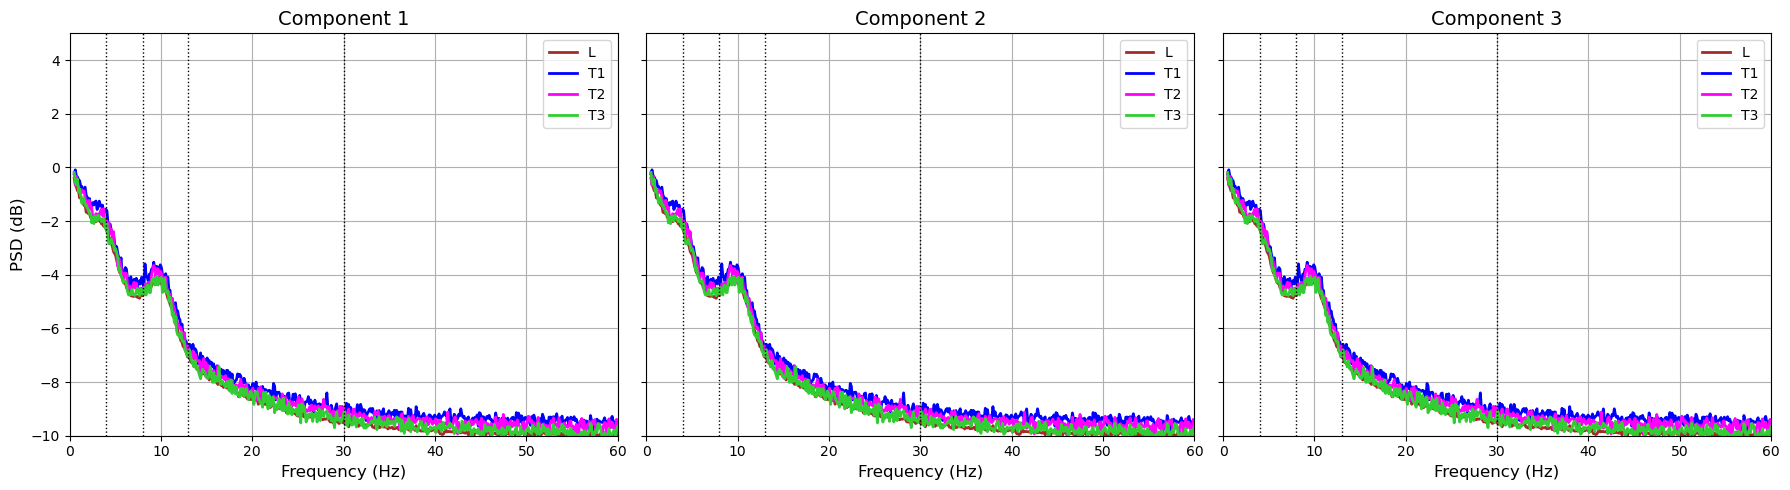

In [ ]:
def plot_eeg_psd_with_corrca(raw, fmin=0.5, fmax=45, picks='eeg', n_components=3):
    """
    从原始 EEG 中提取 CorrCA 分量并绘制每个分量的 PSD 频谱图。
    """
    # === Step 1: 获取 EEG 数据 ===
    raw_data = raw.get_data(picks=picks)  # shape: (n_channels, n_times)
    X = raw_data.T  # shape: (n_times, n_channels)

    # === Step 2: CorrCA 提取主分量 ===
    components = run_corrca(X, n_components=n_components)  # (n_times, n_components)

    # === Step 3: 计算每个 component 的 PSD ===
    fig, axes = plt.subplots(n_components, 1, figsize=(12, 4 * n_components), sharex=True)

    for i in range(n_components):
        data = components[:, i]
        psd, freqs = mne.time_frequency.psd_array_welch(
            data[np.newaxis, :], sfreq=raw.info['sfreq'],
            fmin=fmin, fmax=fmax, n_fft=2048
        )
        psd_db = 10 * np.log10(psd[0])

        ax = axes[i] if n_components > 1 else axes
        ax.plot(freqs, psd_db, label=f'CorrCA Component {i+1}')
        ax.set_title(f"PSD of CorrCA Component {i+1}")
        ax.set_ylabel("Power (dB)")
        ax.grid(True)
        ax.legend(fontsize='small')

    plt.xlabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()


plot_eeg_psd_with_corrca(raw)

In [ ]:
# Exclude the non brain and other sources

labels = ic_labels["labels"]
exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
print(f"Excluding these ICA components: {exclude_idx}")
ica.exclude = exclude_idx

In [ ]:
reconst_raw = raw_downsampled.copy()
ica.apply(reconst_raw, exclude=exclude_idx)
reconst_raw.filter(1, 40, fir_design='firwin')

In [ ]:
 def plot_by_band(raw, fmin=0.5, fmax=45, picks='eeg', channel=None):   
    bands = {
        'Delta (0.5, 4 Hz)': (0.5, 4),
        'Theta (4, 8 Hz)': (4, 8),
        'Alpha (8, 13 Hz)': (8, 13),
        'Beta (13, 30 Hz)': (13, 30),
        'Gamma (30, 45 Hz)': (30, 45),
    }


    for band_name, (low, high) in bands.items():
        ax.axvspan(low, high, alpha=0.2, label=band_name)

    ax.set_title("EEG Power Spectral Density (Welch's Method)")
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectral Density (dB)")
    ax.set_xlim(fmin, fmax)
    ax.legend(loc='upper right', fontsize='small')
    ax.grid(True)
    plt.tight_layout()
    plt.show()